In [1]:
#!pip install matplotlib
#!pip install sympy

In [2]:
from scipy.io import loadmat
import numpy as np
from numpy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle 

from scipy.optimize import fsolve
from math import exp
from numpy import sin, cos
from tqdm import tqdm

# **The cart and pole system**

Consider the cart-and-pole system here depicted:
<div>
<img src="https://drive.google.com/uc?export=view&id=1Yu5zZ57OEEYZ678yWLaU7h-Wq3M9vV9E" width="200">
</div>
whose dynamics follows the following equations:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}
>>>>>>>>>>>>>>>>>>>>>>>>$(*)$

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

where $g = 9.8\,\text{m/sec}$ is the gravitational acceleration, $m_c = 1\,\text{kg}$ is the cart mass, $m_p = 0.1\,\text{kg}$ is the pole mass, $l = 0.5\,\text{m}$ is the half-pole length, $\mu_p = 0.000002$ is the pole on cart friction coefficient, and $F:|F|\leq 10\,\text{N}$ is the force applied to cart's center of mass.

# 1.   Clearly define the state vector $x$ and the control input vector $u$. Define also the domains to which they belong, $X$ and $U$ respectively.

The state vector  is:
$$
x = \left( \begin{array}{ccc}
                \theta \\
                \dot \theta \\
                p_c \\
                \dot p_c
\end{array} \right)
=
\left( \begin{array}{ccc}
                  x_1 \\
                  x_2 \\
                  x_3 \\
                  x_4
\end{array} \right)
$$

Where:
- $\theta \in [-\pi,\pi[$ is the angular position
- $\dot \theta$ is the angular velocity
- $p_c \in [-5, 5]$ is the linear position 
- $\dot p_c$ is the linear velocity


The control input  is the force applied to the cart: $u = F$ with the constraint that $|F| < 10$.

# 2.   Compute the equilibrium state $\bar{x}$ when the control input $\bar{u}$ is set equal to $0$.



To calculate the equilibrium state, I have to solve the state equation when I are already at an equilibrium state and see that this state doesn't change. Since I am dealing with an understandable physical syste, I can assume the equilibrium state to be $(0,0,0,0)$, when the applied $F=0$. Let's check this

In [3]:
g = 9.8 # gravitational acceleration
mc = 1  # cart mass [kg]
l = 0.5 # half-pole length [m]
m = 0.1 # pole mass [kg]
miup = 2e-6 # pole friction coefficient

# let's set the input force to 0
F = 0 # N

In [4]:
def equations(vars):
    x1, x2, x3, x4 = vars
    d_x1 = x2
    d_x2 = (g*sin(x1)+ cos(x1)*((-F-m*l*(x2**2)*sin(x1))/(mc+m))-((miup*x2)/(m*l))) / (l*((4/3)-((m*(cos(x1)**2))/(mc+m))))

    d_x3 = x4
    d_x4 = (F+m*l*((x2**2)*sin(x1)-d_x2*cos(x1)))/(mc+m)

    return [d_x1, d_x2, d_x3, d_x4]

[
    fsolve(equations, (0, 0, 0, 0)),
    fsolve(equations, (3, 0, 0, 0)),
    fsolve(equations, (0, 0, 10, 0))
]

[array([0., 0., 0., 0.]),
 array([3.14159265e+00, 5.56038935e-25, 4.60220307e+03, 0.00000000e+00]),
 array([ 0.,  0., 10.,  0.])]

The equilibrium states are:

$$
x = \left( \begin{array}{ccc}
                \theta = k \pi \; \forall k \in \mathbb{N} \\
                \dot \theta =0 \\
                p_c \in \mathbb{R} \\
                \dot p_c =0
\end{array} \right)
$$

This makes sense, since the position doesn't affect the pole's stability (only the cart's velocity) and the pole has two stability points (straight up, which is unstable and straight down, which is stable).

## Check for stability or instability of the equilibrium states

To check for (in)stability of the equilibrium point, I will plot the simulation of the step response. If the point is stable, we will see a flat line, otherwise a divergent curve from the stability point.

Another way of checking the stability would be to linearise the system, calculate the Jacobian matrix and then extract the eigenvalues, but the method I'm using is simpler and since I don't have many points to examine I think it makes sense to do it like this.

In [5]:
def cart_and_pole_odeint(x, t, F):
  dxdt = np.zeros_like(x)

  dxdt[0] = x[1] #tetap
  dxdt[1] = (g*sin(x[0])+ cos(x[0])*((-F-m*l*(x[1]**2)*sin(x[0]))/(mc+m))-((miup*x[1])/(m*l))) / (l*((4/3)-((m*(cos(x[0])**2))/(mc+m))))    #teta2p
  dxdt[2] = x[3] #xp
  dxdt[3] = (F+m*l*((x[1]**2)*sin(x[0])-dxdt[1]*cos(x[0])))/(mc+m) #x2p
  return dxdt

In [6]:
MAIN_TIME_STEP = 0.02
time_step = MAIN_TIME_STEP
x0_odeint = np.array([0.0, 0.0, 0.0, 0.0])

t0_odeint = 0
t1_odeint = t0_odeint + time_step
t_odeint = np.array([t0_odeint, t1_odeint])

X_odeint = np.array([x0_odeint])

In [7]:
time_sim = np.arange(0.0, 5, time_step)

for i in range(len(time_sim) - 1):
    F = 10 if i == 0 else 0
    x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
    x0_odeint = x_odeint[1]
    X_odeint=np.append(X_odeint, [x0_odeint], axis= 0)

Text(0.5, 1.0, 'dot p_c(t)')

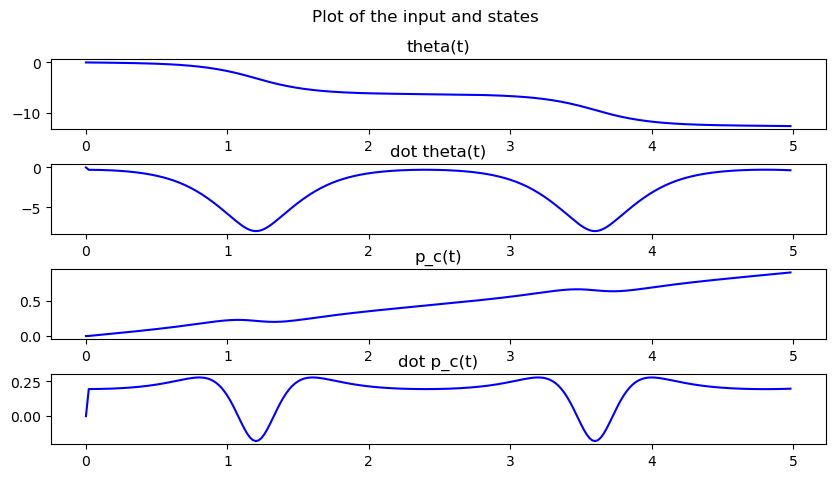

In [8]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(4)
fig.subplots_adjust(hspace=0.5)

fig.suptitle("Plot of the input and states")

axs[0].plot(time_sim, X_odeint[:,0], 'b')
axs[0].set_title("theta(t)")

axs[1].plot(time_sim, X_odeint[:,1], 'b')
axs[1].set_title("dot theta(t)")

axs[2].plot(time_sim, X_odeint[:,2], 'b')
axs[2].set_title("p_c(t)")

axs[3].plot(time_sim, X_odeint[:,3], 'b')
axs[3].set_title("dot p_c(t)")

After having a look at those charts, we can state that $(0,0,0,0)$ is a unstable equilibrium point.

In [9]:
MAIN_TIME_STEP = 0.02
time_step = MAIN_TIME_STEP
x0_odeint = np.array([np.pi, 0.0, 0.0, 0.0])

t0_odeint = 0
t1_odeint = t0_odeint + time_step
t_odeint = np.array([t0_odeint, t1_odeint])

X_odeint = np.array([x0_odeint])

time_sim = np.arange(0.0, 5, time_step)

for i in range(len(time_sim) - 1):
    F = 10 if i == 0 else 0
    x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
    x0_odeint = x_odeint[1]
    X_odeint=np.append(X_odeint, [x0_odeint], axis= 0)
    
plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(4)
fig.subplots_adjust(hspace=0.5)

fig.suptitle("Plot of the input and states")

axs[0].plot(time_sim, X_odeint[:,0], 'b')
axs[0].set_title("theta(t)")

axs[1].plot(time_sim, X_odeint[:,1], 'b')
axs[1].set_title("dot theta(t)")

axs[2].plot(time_sim, X_odeint[:,2], 'b')
axs[2].set_title("p_c(t)")

axs[3].plot(time_sim, X_odeint[:,3], 'b')
axs[3].set_title("dot p_c(t)")

Text(0.5, 1.0, 'dot p_c(t)')

Instead, $(\pi,0,0,0)$ is a stable equilibrium point. Desplite the oscillation, which can be due to `odeint` approximations, we can see that the angle is not varying much around the equilibrium point.

# 3.   Given the sequence of control inputs $\left[u^{(0)},\,u^{(1)},\cdots,u^{(100)}\right]=\left[\right]$ simulate the behavior of the non linear system $(*)$



The steps that will be executed will be:
1. loading the data
2. simulating the system
3. plotting the state

In [9]:
uvec = loadmat('U.mat')
uvec = uvec['U'][0]

The following function will describe the dynamic:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

To simulate the system the integral between two consecutive time instants is being calculated using the function odeint

In [10]:
x0_odeint = np.array([0.0, 0.0, 0.0, 0.0])

X_odeint = np.array([x0_odeint])

In [11]:
for i in range(len(uvec) - 1):
    F = uvec[i]
    x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
    x0_odeint = x_odeint[1]
    X_odeint=np.append(X_odeint, [x0_odeint], axis= 0)

In [12]:
X_odeint_nonlin = X_odeint.copy()

Text(0.5, 1.0, 'dot p_c(t)')

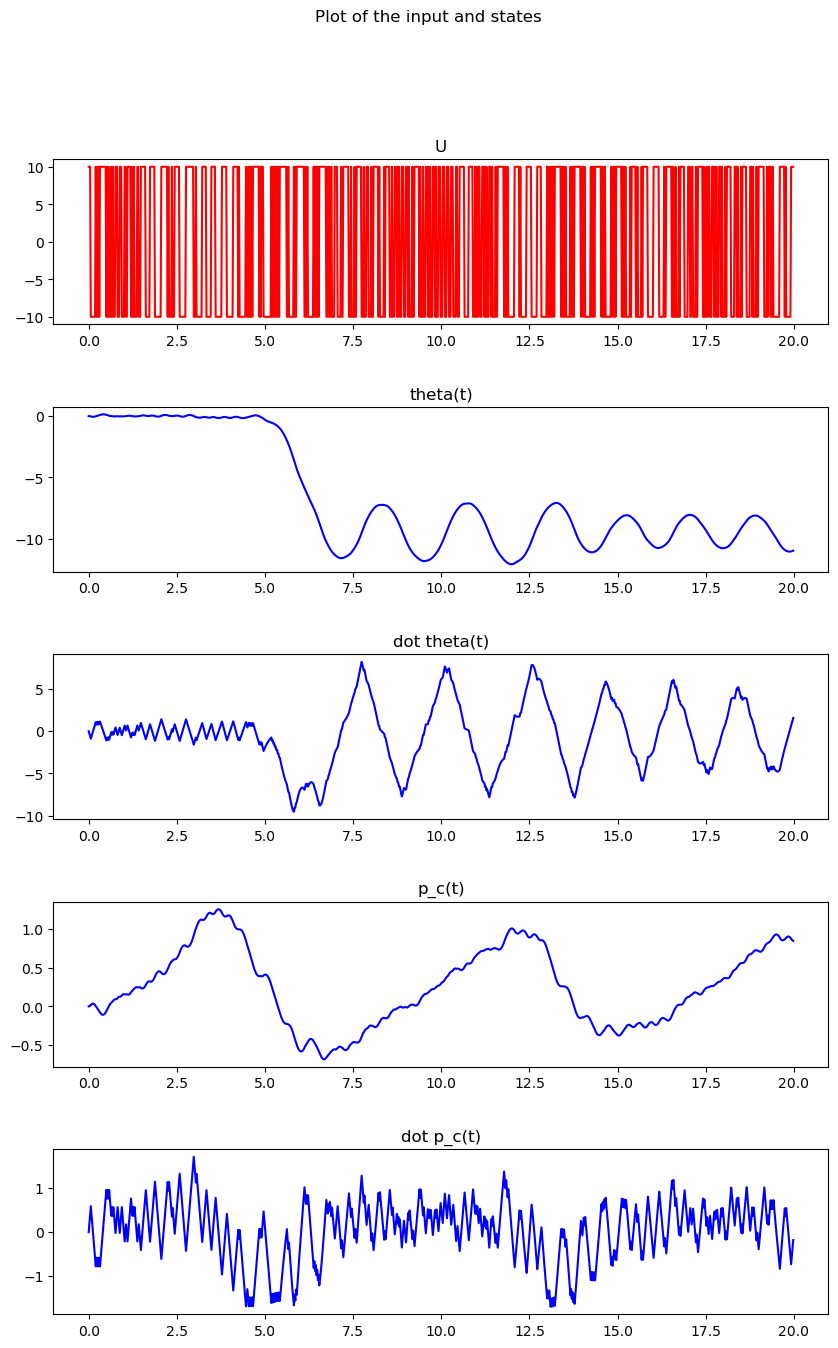

In [13]:
time_sim = np.arange(0.0, 20, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(5)
fig.subplots_adjust(hspace=0.5)

fig.suptitle("Plot of the input and states")

axs[0].plot(time_sim, uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim, X_odeint[:,0], 'b')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim, X_odeint[:,1], 'b')
axs[2].set_title("dot theta(t)")

axs[3].plot(time_sim, X_odeint[:,2], 'b')
axs[3].set_title("p_c(t)")

axs[4].plot(time_sim, X_odeint[:,3], 'b')
axs[4].set_title("dot p_c(t)")

## Try diﬀerent settings of the systems: initial conditions, and time-step size. Create a code that plots signiﬁcant behavior.

In [14]:
time_step = 0.04
x0_odeint = np.array([0.0, 0.0, 0.0, 0.0])

t0_odeint = 0
t1_odeint = t0_odeint + time_step
t_odeint = np.array([t0_odeint, t1_odeint])

X_odeint2 = [x0_odeint]

for i in tqdm(range(int(len(uvec) * MAIN_TIME_STEP / time_step - 1))):
    F = uvec[int(i * time_step / MAIN_TIME_STEP)]
    x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
    x0_odeint = x_odeint[1]
    X_odeint2 = np.append(X_odeint2, [x0_odeint], axis= 0)

100%|██████████| 499/499 [00:00<00:00, 2542.37it/s]


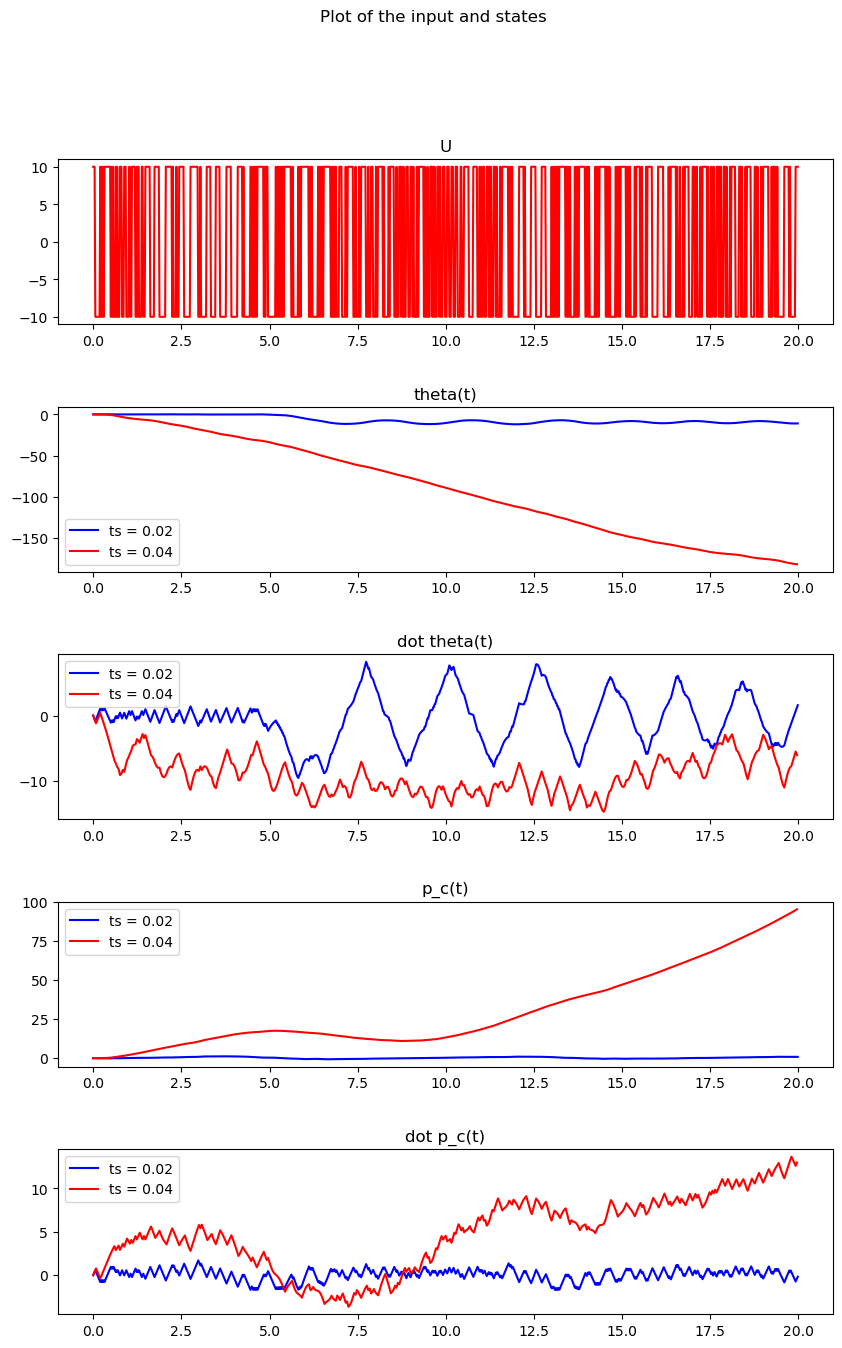

In [15]:
time_sim2 = np.arange(0.0, 20, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(5)
fig.subplots_adjust(hspace=0.5)

fig.suptitle("Plot of the input and states")

axs[0].plot(time_sim, uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim, X_odeint[:,0], 'b')
axs[1].plot(time_sim2, X_odeint2[:,0], 'r')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim, X_odeint[:,1], 'b')
axs[2].plot(time_sim2, X_odeint2[:,1], 'r')
axs[2].set_title("dot theta(t)")

axs[3].plot(time_sim, X_odeint[:,2], 'b')
axs[3].plot(time_sim2, X_odeint2[:,2], 'r')
axs[3].set_title("p_c(t)")

axs[4].plot(time_sim, X_odeint[:,3], 'b')
axs[4].plot(time_sim2, X_odeint2[:,3], 'r')
axs[4].set_title("dot p_c(t)")

for i in range(1,5):
    axs[i].legend([f"ts = {MAIN_TIME_STEP}", f"ts = {time_step}"])

The behavior is different because when I do 
```python 
uvec[int(i * time_step / MAIN_TIME_STEP)]
```

the sampled uvec is leading to a different state behavior.

Now let's have a look at the free state response when supplying a discrete impulse.

In [16]:
time_step = MAIN_TIME_STEP
x0_odeint = np.array([0.0, 0.0, 0.0, 0.0])

uvec2 = uvec.copy()
uvec = np.zeros_like(uvec)
uvec += 10

t0_odeint = 0
t1_odeint = t0_odeint + time_step
t_odeint = np.array([t0_odeint, t1_odeint])

X_odeint = np.array([x0_odeint])

for i in range(len(uvec) - 1):
    F = uvec[i]
    x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
    x0_odeint = x_odeint[1]
    X_odeint=np.append(X_odeint, [x0_odeint], axis= 0)

time_step = 0.04
x0_odeint = np.array([0.0, 0.0, 0.0, 0.0])

t0_odeint = 0
t1_odeint = t0_odeint + time_step
t_odeint = np.array([t0_odeint, t1_odeint])

X_odeint2 = [x0_odeint]

for i in tqdm(range(int(len(uvec) * MAIN_TIME_STEP / time_step - 1))):
    F = uvec[i]
    x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
    x0_odeint = x_odeint[1]
    X_odeint2 = np.append(X_odeint2, [x0_odeint], axis= 0)

100%|██████████| 499/499 [00:00<00:00, 2841.65it/s]


In [17]:
time_sim2 = np.arange(0.0, 20, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(5)
fig.subplots_adjust(hspace=0.5)

fig.suptitle("Plot of the input and states")

axs[0].plot(time_sim, uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim, X_odeint[:,0], 'b')
axs[1].plot(time_sim2, X_odeint2[:,0], 'r')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim, X_odeint[:,1], 'b')
axs[2].plot(time_sim2, X_odeint2[:,1], 'r')
axs[2].set_title("dot theta(t)")

axs[3].plot(time_sim, X_odeint[:,2], 'b')
axs[3].plot(time_sim2, X_odeint2[:,2], 'r')
axs[3].set_title("p_c(t)")

axs[4].plot(time_sim, X_odeint[:,3], 'b')
axs[4].plot(time_sim2, X_odeint2[:,3], 'r')
axs[4].set_title("dot p_c(t)")

for i in range(1,5):
    axs[i].legend([f"ts = {MAIN_TIME_STEP}", f"ts = {time_step}"])

In [18]:
uvec = uvec2.copy()

If I feed the same input the results stays the same, but I have to pay attention that sampling at different sample rate can cause a different input signal to be fed to the system, thus causing a different response.

# 4.   Given the non linear system (∗) linearize it around the equilibrium point computed in the point 2 and simulate the behavior of the linear systems given the same sequence of control inputs of point 3.

To linearize the system, I will make use of symbolic calculation. I have to replace the variables on the state equation and then derive (Taylor's series) each of them and substitute all the variables that I already know, since I'm already at an equilibrium state.

In [19]:
import sympy as sym
from sympy import sin, cos

In [20]:
x1 = sym.Symbol("x1")
x2 = sym.Symbol("x2")
x3 = sym.Symbol("x3")
x4 = sym.Symbol("x4")
F = sym.Symbol("F")
x = [x1,x2,x3,x4]
xeq = [0,0,0,0]
ueq = 0

In [21]:
theta2p = ((g*sin(x[0]))+(cos(x[0])*((-F-(m*l*(x[1]**2)*sin(x[0])))/(mc+m)))-((miup*x[1])/(m*l)))/(l*((4/3)-((m*((cos(x[0]))**2))/(mc+m))))
x2p = (F+(m*l*(((x[1]**2)*sin(x[0]))-((((g*sin(x[0]))+(cos(x[0])*((-F-(m*l*(x[1]**2)*sin(x[0])))/(mc+m)))-((miup*x[1])/(m*l)))/(l*((4/3)-((m*((cos(x[0]))**2))/(mc+m)))))*cos(x[0])))))/(mc+m)

I first linearize the components for the A matrix, then the B matrix.

In [22]:
theta2p_linA = []
for i in range(len(x)):
    lin = sym.diff(theta2p, x[i]) # evaluate the partial derivative
    lin = lin.subs(F, ueq)
    for j in range(len(x)):
        lin = lin.subs(x[j], xeq[j]) # replace equilibrium points
    theta2p_linA.append(lin)
theta2p_linA

[15.7756097560976, -6.43902439024390e-5, 0, 0]

In [23]:
theta2p_linB = sym.diff(theta2p, F)
for j in range(len(x)):
    theta2p_linB = theta2p_linB.subs(x[j], xeq[j]) # replace equilibrium points
theta2p_linB

-1.46341463414634

In [24]:
x2p_linA = []
for i in range(len(x)):
    lin = sym.diff(x2p, x[i]) # evaluate the partial derivative
    lin = lin.subs(F, ueq)
    for j in range(len(x)):
        lin = lin.subs(x[j], xeq[j]) # replace equilibrium points
    x2p_linA.append(lin)
x2p_linA

[-0.717073170731708, 2.92682926829268e-6, 0, 0]

In [25]:
x2p_linB = sym.diff(x2p, F)
for j in range(len(x)):
    x2p_linB = x2p_linB.subs(x[j], xeq[j]) # replace equilibrium points
x2p_linB

0.975609756097561

Here in the lines 7-9 and 14-16, the linear system is being reconstructed

In [26]:
def cart_and_pole_lin(x, t, F):
    dxdt = np.zeros_like(x)

    dxdt[0] = x[1] #thetap
    
    dxdt[1] = 0 #theta2p
    for i in range(len(x)):
        dxdt[1] += theta2p_linA[i]*(x[i] - xeq[i])
    dxdt[1] += theta2p_linB * (F - ueq)
    
    dxdt[2] = x[3] #xp
    
    dxdt[3] = 0 #x2p
    for i in range(len(x)):
        dxdt[3] += x2p_linA[i]*(x[i] - xeq[i])
    dxdt[3] += x2p_linB * (F - ueq)
    
    return dxdt

In [27]:
linearized_model = {
    "theta2p_linA": theta2p_linA,
    "theta2p_linB": theta2p_linB,
    "x2p_linA": x2p_linA,
    "x2p_linB": x2p_linB
}
with open('linearized_model.pkl', 'wb') as file: 
    pickle.dump(linearized_model, file) 

In [28]:
time_step=0.02
t0_odeint=0
x0_odeint = np.array([0.0, 0.0, 0.0, 0.0])
X_odeint=[x0_odeint]

In [29]:
for i in tqdm(range(len(uvec) - 1)):
  t1_odeint = t0_odeint+0.02
  t_odeint = np.array([t0_odeint, t1_odeint])
  F = uvec[i]
  x_odeint = odeint(cart_and_pole_lin, x0_odeint, t_odeint, args=(F, ))
  x0_odeint = x_odeint[1]
  X_odeint=np.append(X_odeint, [x0_odeint], axis= 0)

  2%|▏         | 24/999 [00:00<00:23, 41.91it/s]100%|██████████| 999/999 [00:16<00:00, 62.39it/s]


In [30]:
time_sim = np.arange(0.0, 20, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(5)
fig.subplots_adjust(hspace=0.5)

fig.suptitle("Plot of the input and states")

axs[0].plot(time_sim, uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim, X_odeint[:,0], 'b')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim, X_odeint[:,1], 'b')
axs[2].set_title("dot theta(t)")

axs[3].plot(time_sim, X_odeint[:,2], 'b')
axs[3].set_title("p_c(t)")

axs[4].plot(time_sim, X_odeint[:,3], 'b')
axs[4].set_title("dot p_c(t)")

Text(0.5, 1.0, 'dot p_c(t)')

# 5.   Comment the results obtained in point 3 and 4. Do you observe any difference?



The gotten results at the points 3 and 4 are profoundly different and the main reason is that in the second case I'm using a linearised system far away from it's equilibrium point and this will lead to unavoidable errors as the system is moving away from the equilibrium. Supplying a $F=\pm 10$ is not the best to stay close to $(0,0,0,0)$.

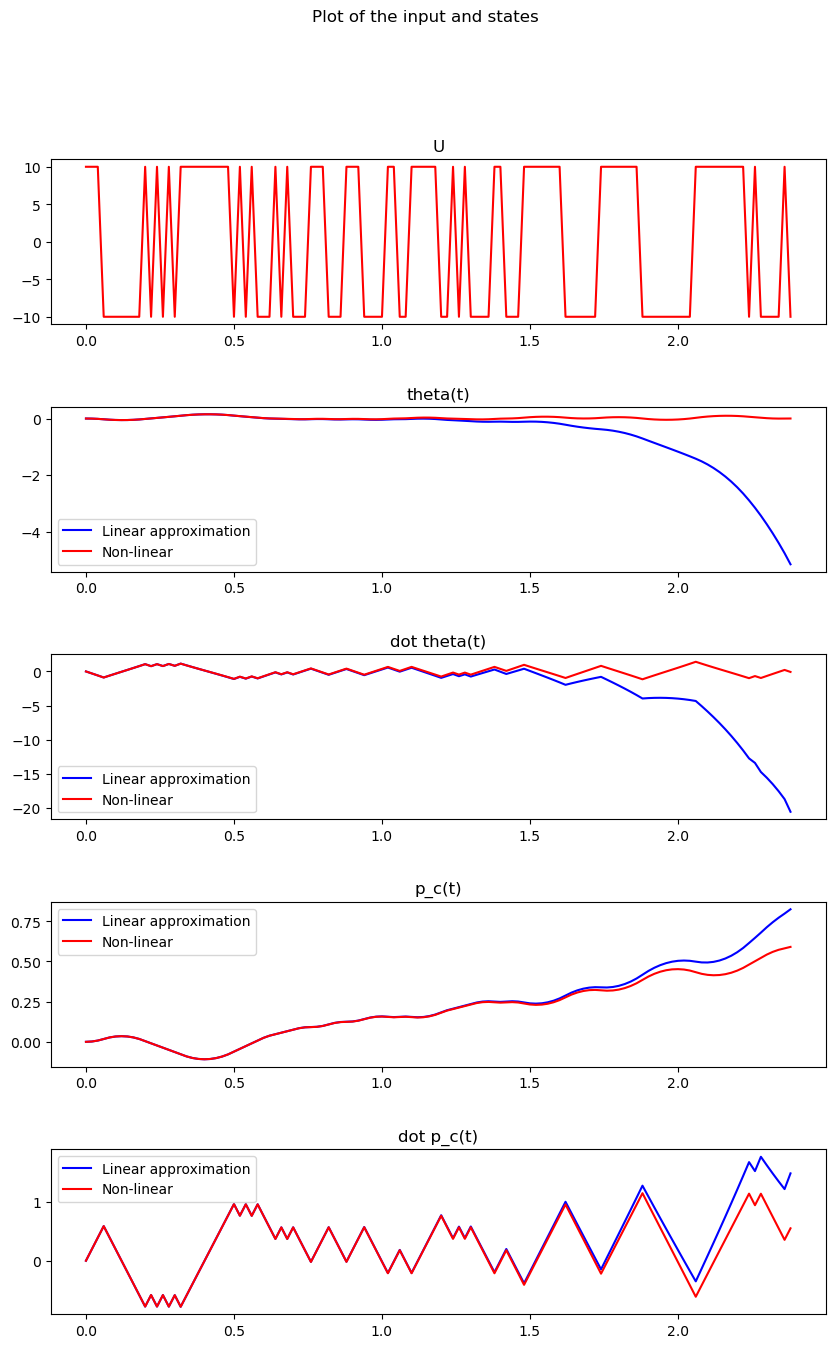

In [31]:
HOW_MANY = 120
time_sim = np.arange(0.0, 20, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(5)
fig.subplots_adjust(hspace=0.5)

fig.suptitle("Plot of the input and states")

axs[0].plot(time_sim[:HOW_MANY], uvec[:HOW_MANY], 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim[:HOW_MANY], X_odeint[:HOW_MANY,0], 'b')
axs[1].plot(time_sim[:HOW_MANY], X_odeint_nonlin[:HOW_MANY,0], 'r')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim[:HOW_MANY], X_odeint[:HOW_MANY,1], 'b')
axs[2].plot(time_sim[:HOW_MANY], X_odeint_nonlin[:HOW_MANY,1], 'r')
axs[2].set_title("dot theta(t)")

axs[3].plot(time_sim[:HOW_MANY], X_odeint[:HOW_MANY,2], 'b')
axs[3].plot(time_sim[:HOW_MANY], X_odeint_nonlin[:HOW_MANY,2], 'r')
axs[3].set_title("p_c(t)")

axs[4].plot(time_sim[:HOW_MANY], X_odeint[:HOW_MANY,3], 'b')
axs[4].plot(time_sim[:HOW_MANY], X_odeint_nonlin[:HOW_MANY,3], 'r')
axs[4].set_title("dot p_c(t)")

for i in range(1,5):
    axs[i].legend([f"Linear approximation", f"Non-linear"])

Despite this, in the last charts I can notice that in the beginning of the simulation, the linearized version of the system is actually behaving well, but as the simulation moves farther away from the equilibrium point, the two simulations start to diverge. After 2s the behavior is such that there will be an exponential divergence thus the initial part of the simulation (which is more or less correct) will not be visible.